In [1]:
import sys
sys.path.append('E:/zlab/')
from loader import Loader
# ----------------

import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tables as tb
import mxnet as mx
from mxnet import nd, autograd, gluon
import gluonbook as gb
from mxnet import gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo, nn
from sklearn.semi_supervised.label_propagation import LabelSpreading
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from mxboard import SummaryWriter

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 载入数据

In [2]:
import tables as tb

h5 = tb.open_file('E:/xdata/X.h5')
#h5 = tb.open_file('./X.h5')

data = h5.root.cifar10

## 划分数据集

In [3]:
from sklearn.model_selection import train_test_split

X = data.trainX[:]
y = data.trainY[:]
X_train, X_unlabel, y_train, y_unlabel = train_test_split(
    X, y, test_size=0.98, random_state=42)

batch_size = 32
trainset = Loader(batch_size, X_train, y_train, shuffle=True, name='train')
testset = Loader(
    batch_size, data.testX, data.testY, shuffle=False, name='test')
unlabelset = Loader(
    batch_size,
    X_unlabel[:10000],
    y_unlabel[:10000],
    shuffle=False,
    name='agent')

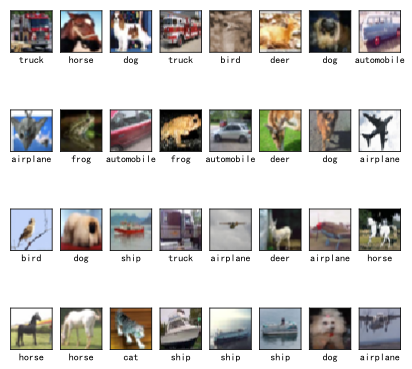

In [4]:
for imgs, labels in iter(trainset):
    trainset.show_imgs(data.label_names, imgs.astype(np.uint8), labels)
    break

# 模型的配置

In [5]:
class SemiModel(nn.HybridBlock):
    def __init__(self, features, **kwargs):
        super().__init__(**kwargs)
        self.features = features[:10]
        self.output = nn.Dense(10)
        
    def hybrid_forward(self, F, x):
        x = self.features(x)
        return self.output(x)

pretrain_net = model_zoo.vision.resnet50_v2(pretrained=False)
net = SemiModel(pretrain_net.features)

# 网络预设
_net = model_zoo.vision.resnet50_v2(pretrained=True)
net.features = _net.features[:10]
net.features.add(nn.Flatten())
net.features[-1].initialize(init.Xavier())
net.output.initialize(init.Xavier(magnitude=2.24))

# 模型超参数设定

In [6]:
from xtrain import XModel

# 超参数设定
epochs = 1000
learning_rate = 0.15
model = XModel(learning_rate)
ctx = model.ctx
print('training on', ctx)
net.collect_params().reset_ctx(ctx)
net.hybridize()

training on gpu(0)


# 数据打包

In [21]:
class Bunch(dict):
    def __init__(self, ctx, batch_size, trainset, unlabelset, *args, **kwargs):
        '''
        初始化数据迭代器和标签传播算法
        '''
        self.__dict__ = self
        self.ctx = ctx
        self.train = trainset
        self.unlabel = unlabelset
        self.feature_l = self.train.X.reshape(((-1, 32 * 32 * 3)))
        self.feature_u = self.unlabel.X.reshape(((-1, 32 * 32 * 3)))


bunch = Bunch(ctx, batch_size, trainset, unlabelset)

In [25]:
bunch.feature_u.shape

(10000, 3072)

In [17]:
from sklearn.metrics.pairwise_distances import 

(10000, 32, 32, 3)

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

a = [[1, 3], [2, 2]]
cosine_similarity(a)

array([[1.        , 0.89442719],
       [0.89442719, 1.        ]])

In [27]:
pairwise_distances(a,metric="cosine")

array([[0.        , 0.10557281],
       [0.10557281, 0.        ]])

# 训练和调优